### Group 4 ADS508 Final Project

Monitoring Water Quality | Released by Tech-AAB

Team: Parisa Kamizi, Landon Padgett, Vicky van der Wagt

-----------------------------------------------------------------------

**Import libraries and packages**

In [5]:
import pandas as pd
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


**Download data from s3 into the "data" folder"**

*Commented out because it only needs to be done once*

In [8]:
#!aws s3 cp 's3://ads508group4finalproject/stations.csv' ./data/
#!aws s3 cp 's3://ads508group4finalproject/field_results.csv' ./data/
#!aws s3 cp 's3://ads508group4finalproject/lab_results.csv' ./data/
#!aws s3 cp 's3://ads508group4finalproject/period_of_record.csv' ./data/

In [9]:
st = pd.read_csv("./data/stations.csv")
fr = pd.read_csv("./data/field_results.csv")
lr = pd.read_csv("./data/lab_results.csv")
por = pd.read_csv("./data/period_of_record.csv")

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Exploration

**Compare df # of rows and columns**

In [10]:
import pandas as pd

#generate dictionary
df_data = {
    'df': ['st', 'por', 'fr', 'lr'],
    'df longname': ['Stations', 'Period of Record', 'Field Results', 'Lab Results'],
    '# of Rows': [st.shape[0], por.shape[0], fr.shape[0], lr.shape[0]],
    '# of Columns': [st.shape[1], por.shape[1], fr.shape[1], lr.shape[1]]
}

#convert dictionary into dataframe
df_info = pd.DataFrame(df_data)

#print dataframe
print(tabulate(df_info, headers='keys', tablefmt='fancy_grid'))


╒════╤══════╤══════════════════╤═════════════╤════════════════╕
│    │ df   │ df longname      │   # of Rows │   # of Columns │
╞════╪══════╪══════════════════╪═════════════╪════════════════╡
│  0 │ st   │ Stations         │       44475 │             11 │
├────┼──────┼──────────────────┼─────────────┼────────────────┤
│  1 │ por  │ Period of Record │      733915 │             12 │
├────┼──────┼──────────────────┼─────────────┼────────────────┤
│  2 │ fr   │ Field Results    │     1199457 │             22 │
├────┼──────┼──────────────────┼─────────────┼────────────────┤
│  3 │ lr   │ Lab Results      │     4610840 │             18 │
╘════╧══════╧══════════════════╧═════════════╧════════════════╛


**Explore Stations**

In [11]:
st.info()
st.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44475 entries, 0 to 44474
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         44475 non-null  int64  
 1   station_name       44475 non-null  object 
 2   full_station_name  44475 non-null  object 
 3   station_number     44475 non-null  object 
 4   station_type       44475 non-null  object 
 5   latitude           44197 non-null  float64
 6   longitude          44197 non-null  float64
 7   county_name        44475 non-null  object 
 8   sample_count       44475 non-null  int64  
 9   sample_date_min    44475 non-null  object 
 10  sample_date_max    44475 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,county_name,sample_count,sample_date_min,sample_date_max
0,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0000,-121.0000,Yolo,1,06/23/2008 15:00,06/23/2008 15:00
1,6134,01N01E33K001M,01N01E33K001M,01N01E33K001M,Groundwater,37.8868,-121.8682,Contra Costa,1,05/20/1981 13:45,05/20/1981 13:45
2,6135,01N01W03N001M,01N01W03N001M,01N01W03N001M,Groundwater,37.9583,-121.9669,Contra Costa,9,07/23/1974 15:15,08/16/1990 12:15
3,6136,01N01W04A001M,01N01W04A001M,01N01W04A001M,Groundwater,37.9663,-121.9734,Contra Costa,9,08/04/1972 15:00,09/15/1989 08:00
4,6137,01N01W07K001M,01N01W07K001M,01N01W07K001M,Groundwater,37.9460,-122.0155,Contra Costa,9,08/03/1973 09:30,09/15/1989 09:15


**See number of stations per county**

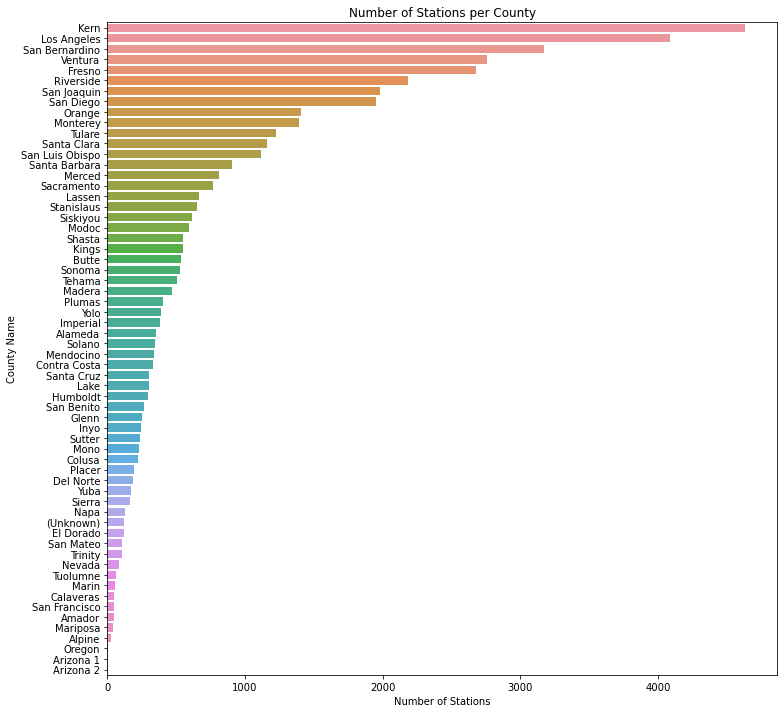

In [12]:
county_station_counts = st['county_name'].value_counts().reset_index()
county_station_counts.columns = ['county_name', 'station_count']

plt.figure(figsize=(12, 12))
sns.barplot(x='station_count', y='county_name', data=county_station_counts)
plt.xlabel('Number of Stations')
plt.ylabel('County Name')
plt.title('Number of Stations per County')
plt.show()


In [13]:
san_diego_stations_count = st[st['county_name'] == 'San Diego'].shape[0]
print("number of San Diego stations:", san_diego_stations_count)

number of San Diego stations: 1948


We have the option to filter for San Diego stations during data processing. This will leave us with 1948 stations remaining.

**See Distribution of Station Types**

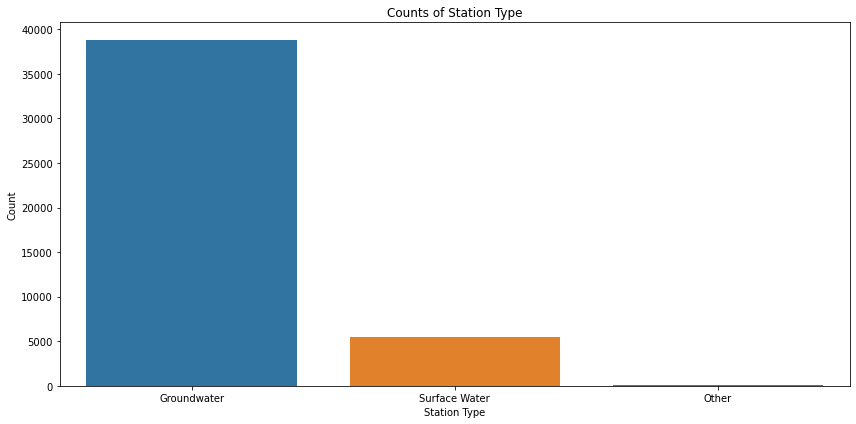

In [14]:
#get count of station types
station_type_counts = st['station_type'].value_counts()

#generate plot
plt.figure(figsize=(12, 6))
sns.barplot(x=station_type_counts.index, y=station_type_counts.values)
plt.xlabel('Station Type')
plt.ylabel('Count')
plt.title('Counts of Station Type')
plt.tight_layout()
plt.show()


## Explore Period of Record

In [15]:
por.info()
por.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733915 entries, 0 to 733914
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   station_id         733915 non-null  int64  
 1   station_name       733915 non-null  object 
 2   full_station_name  733915 non-null  object 
 3   station_number     733915 non-null  object 
 4   station_type       733915 non-null  object 
 5   latitude           723662 non-null  float64
 6   longitude          723662 non-null  float64
 7   county_name        733915 non-null  object 
 8   parameter          733915 non-null  object 
 9   sample_count       733915 non-null  int64  
 10  sample_date_min    733915 non-null  object 
 11  sample_date_max    733915 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 67.2+ MB


,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,county_name,parameter,sample_count,sample_date_min,sample_date_max
0,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Aluminum,1,06/23/2008 15:00,06/23/2008 15:00
1,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Antimony,1,06/23/2008 15:00,06/23/2008 15:00
2,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Arsenic,1,06/23/2008 15:00,06/23/2008 15:00
3,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Barium,1,06/23/2008 15:00,06/23/2008 15:00
4,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Beryllium,1,06/23/2008 15:00,06/23/2008 15:00


**Examine the Date Range of Water Quality Collection**

In [16]:
#first convert dates in por to datetime
por['sample_date_min'] = pd.to_datetime(por['sample_date_min'])
por['sample_date_max'] = pd.to_datetime(por['sample_date_max'])

#identify the minimum and max values
min_sample_date_min = por['sample_date_min'].min()
max_sample_date_max = por['sample_date_max'].max()

#print
print("Earliest sample_date_min:", min_sample_date_min)
print("Latest sample_date_max:", max_sample_date_max)


Earliest sample_date_min: 1903-03-23 00:00:00
Latest sample_date_max: 2024-01-04 12:59:00


## Explore Lab Results

In [17]:
lr.info()
lr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4610840 entries, 0 to 4610839
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   station_id          int64  
 1   station_name        object 
 2   full_station_name   object 
 3   station_number      object 
 4   station_type        object 
 5   latitude            float64
 6   longitude           float64
 7   status              object 
 8   county_name         object 
 9   sample_code         object 
 10  sample_date         object 
 11  sample_depth        float64
 12  sample_depth_units  object 
 13  parameter           object 
 14  result              object 
 15  reporting_limit     float64
 16  units               object 
 17  method_name         object 
dtypes: float64(4), int64(1), object(13)
memory usage: 633.2+ MB


,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,status,county_name,sample_code,sample_date,sample_depth,sample_depth_units,parameter,result,reporting_limit,units,method_name
0,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Conductance,3480,1.0,uS/cm,EPA 120.1
1,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Dissolved Boron,7.7,0.1,mg/L,"Std Method 4500-B, C"
2,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Dissolved Calcium,68,1.0,mg/L,EPA 215.2
3,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Dissolved Chloride,758,0.1,mg/L,"Std Method 4500-Cl, B"
4,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Dissolved Magnesium,59,0.1,mg/L,"Std Method 3500-Mg, E"


**Investigate unique tested parameters**

In [18]:
num_unique_parameters_lr = lr['parameter'].nunique()
print("Number of measured parameters:", num_unique_parameters_lr)

Number of measured parameters: 437


This is a lot of parameters - let's just see distribution of top 30 paramters for now. Can filter later on. 

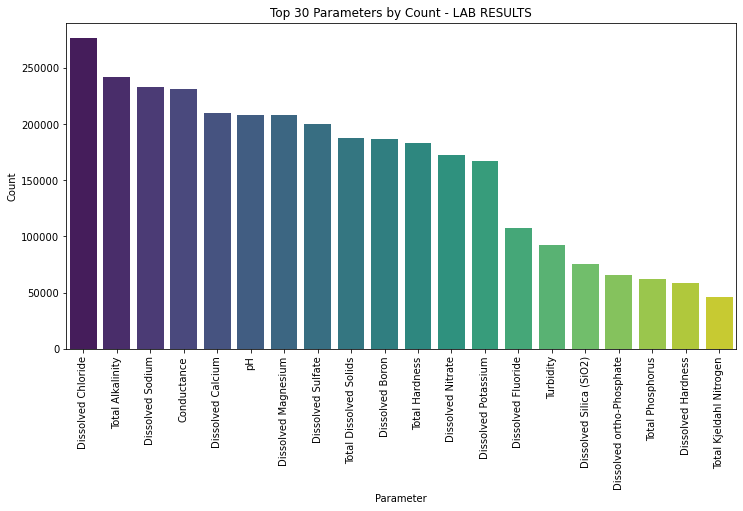

In [19]:
#get the count of each parameter in lr
parameter_counts_lr = lr['parameter'].value_counts()

#generate df for plot
parameter_counts_lr_df = parameter_counts_lr.reset_index()
parameter_counts_lr_df.columns = ['parameter', 'count']

#select top parameters, can change x
x = 20
top_x_parameters_lr = parameter_counts_lr_df.head(20)

#create barplot visualizing the top parameters
plt.figure(figsize=(12, 6))
sns.barplot(x='parameter', y='count', data=top_x_parameters_lr, palette='viridis')
plt.xlabel('Parameter')
plt.ylabel('Count')
plt.title('Top 30 Parameters by Count - LAB RESULTS')
plt.xticks(rotation=90)
plt.show()


Can filter for top x number of parameters further down.

## Explore Field Results

In [20]:
fr.info()
fr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199457 entries, 0 to 1199456
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   station_id           1199457 non-null  int64  
 1   station_name         1199457 non-null  object 
 2   station_number       1199457 non-null  object 
 3   full_station_name    1199457 non-null  object 
 4   station_type         1199457 non-null  object 
 5   latitude             1187572 non-null  float64
 6   longitude            1187572 non-null  float64
 7   status               1199457 non-null  object 
 8   county_name          1199457 non-null  object 
 9   sample_code          1199457 non-null  object 
 10  sample_date          1199457 non-null  object 
 11  sample_depth         634376 non-null   float64
 12  sample_depth_units   1199457 non-null  object 
 13  anl_data_type        136604 non-null   object 
 14  parameter            1199457 non-null  object 
 15

,station_id,station_name,station_number,full_station_name,station_type,latitude,longitude,status,county_name,sample_code,...,sample_depth_units,anl_data_type,parameter,fdr_result,fdr_text_result,fdr_date_result,fdr_reporting_limit,uns_name,mth_name,fdr_footnote
0,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0168A0001,...,Feet,NaN,DissolvedOxygen,9.2,NaN,NaN,0.2,mg/L,EPA 360.2 (Field),NaN
1,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0168A0001,...,Feet,NaN,ElectricalConductance,515.0,NaN,NaN,1.0,uS/cm,Std Method 2510-B (Field),NaN
2,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0168A0001,...,Feet,NaN,WaterTemperature,6.7,NaN,NaN,0.1,°C,EPA 170.1 (Field),NaN
3,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0168A0001,...,Feet,NaN,pH,7.3,NaN,NaN,0.1,pH Units,EPA 150.1 (Field),NaN
4,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0268A0006,...,Feet,NaN,DissolvedOxygen,9.7,NaN,NaN,0.2,mg/L,EPA 360.2 (Field),NaN


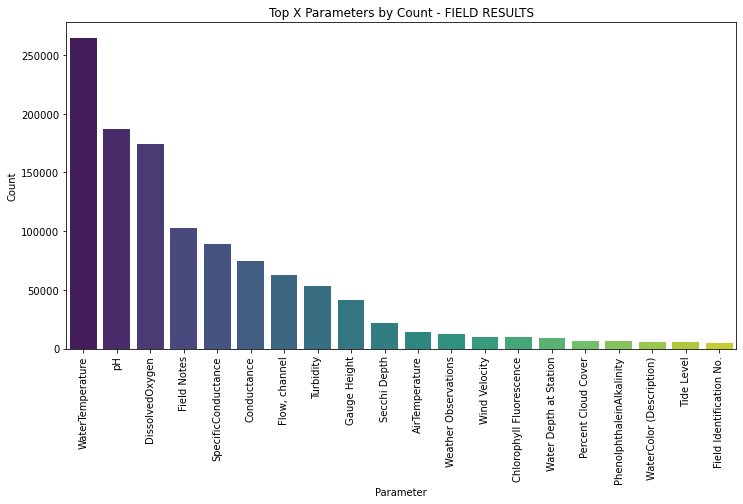

In [21]:
#get the count of each parameter in fr
parameter_counts_fr = fr['parameter'].value_counts()

#generate df for plot
parameter_counts_fr_df = parameter_counts_fr.reset_index()
parameter_counts_fr_df.columns = ['parameter', 'count']

#select top parameters, can change x
x = 20
top_x_parameters_fr = parameter_counts_fr_df.head(20)

#create barplot visualizing the top parameters
plt.figure(figsize=(12, 6))
sns.barplot(x='parameter', y='count', data=top_x_parameters_fr, palette='viridis')
plt.xlabel('Parameter')
plt.ylabel('Count')
plt.title('Top X Parameters by Count - FIELD RESULTS')
plt.xticks(rotation=90)
plt.show()
